In [2]:
import os, sys, json
from pathlib import Path, PosixPath
import imageio

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from scipy.spatial.transform import Rotation
from utils import Sphere, initialize_rays, rendering, apply_camera_transformation, euler_to_rotation_matrix, create_homogeneous_matrix

In [3]:
"""
General folder structure (following nerfstudio convention)
/Folder
    / transforms.json
    / images/
    / images_2/
    / ...
    / images_2^(n-1)/
""";

In [4]:
def initialize_rays(H,W,fx, fy, device="cpu"):
    u,v = np.arange(W), np.arange(H)
    u,v = np.meshgrid(u,v)

    rays_o = np.zeros((H*W, 3))
    rays_d = np.stack((
        (u - W/2)   /fx,
        -(v - H/2) / fy,
        -np.ones_like(u)
    ), axis=-1)

    rays_d = rays_d / np.linalg.norm(rays_d, axis=-1, keepdims=True)
    rays_d = rays_d.reshape(-1, 3)

    rays_o = torch.Tensor(rays_o).to(device)
    rays_d = torch.Tensor(rays_d).to(device)
    
    return rays_o, rays_d

def apply_camera_transformation(rays_o, rays_d, cam2world):
    rays_d = cam2world[:3,:3] @ rays_d.unsqueeze(-1)
    rays_d = rays_d.squeeze(-1)
    rays_o += cam2world[:3, 3]
    return rays_o, rays_d

In [5]:
def get_rays(DIR : PosixPath, max_num_images=None):
    ### Find json file and image folders
    json_path = Path.joinpath(DIR, "transforms.json")
    images_path = [folder for content in os.listdir(DIR.as_posix()) 
                   if os.path.isdir(folder := Path.joinpath(DIR, content).as_posix()) and "images" in folder]
    images_path = sorted(images_path)
    assert os.path.isfile(json_path), f"transforms.json does not exists in directory {DIR}"
    assert len(images_path) > 0, f"There are no images folders in directory {DIR}"
    
    ### Read json file and images
    with open(json_path, "r") as jfile:
        json_file_contents =  json.load(jfile)
    
    image_paths = []
    for ipath in images_path:
        image_paths.append( [os.path.join(ipath, i) for i in os.listdir(ipath)] )
    
    #!!!!! I take only one folder for now
    image_paths = [image_paths[2]]
    #!!!!
    
    assert len(json_file_contents["frames"]) == len(image_paths[0]), "Number of camera poses must match the number of images"
    
    framenames_transforms = [(json_file_contents["frames"][i]["file_path"],json_file_contents["frames"][i]["transform_matrix"]) for i in range(len(json_file_contents["frames"]))]
    framenames_transforms = sorted(framenames_transforms, key=lambda x: x[0])

    all_frames,all_poses = [],[]
    for j in range(len(image_paths)):
        frames,poses = [],[]
        N = len(image_paths[j])
        image_paths_j = sorted(image_paths[j])
        for i in range(N):
            if max_num_images and i == max_num_images: break
            
            frame = imageio.imread(image_paths_j[i]) / 255. # To map to [0,1]
            pose  = np.array(framenames_transforms[i][1])
            frames.append(frame)
            poses.append(pose)
            
        all_frames.append(frames)
        all_poses.append(poses)
        
    all_frames,all_poses = np.concatenate(all_frames),np.concatenate(all_poses)
    
    # RGBA -> RGB
    if all_frames.shape[3] == 4: 
        all_frames = all_frames[...:3] * all_frames[...:-1:] + (1 - all_frames[...:-1:])
    
    N = len(all_frames)

    # TODO: for images_j ...
    H,W = all_frames[0].shape[0], all_frames[0].shape[1]
    rays_o_t, rays_d_t = torch.zeros((N,W*H,3)), torch.zeros((N,W*H,3))
    ground_truths = torch.Tensor(all_frames.reshape(N,H*W,3))
    for i in range(N): # TODO: Apply intrinsic transformations when scaled images are used! 
        c2w = torch.Tensor(all_poses[i])
        fx,fy = json_file_contents["fl_x"], json_file_contents["fl_y"]         
        rays_o, rays_d = initialize_rays(H,W,fx,fy, device="cpu")  
        rays_o, rays_d = apply_camera_transformation(rays_o, rays_d, c2w)
        rays_o_t[i] = rays_o
        rays_d_t[i] = rays_d
        
    return rays_o_t, rays_d_t,ground_truths


In [6]:
rays_o, rays_d, gts = get_rays(PosixPath("/home/pc_5053/nerf/data/ITU-stad-demo-2"), max_num_images=10)

/tmp/ipykernel_3281896/1420631198.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_paths_j[i]) / 255. # To map to [0,1]


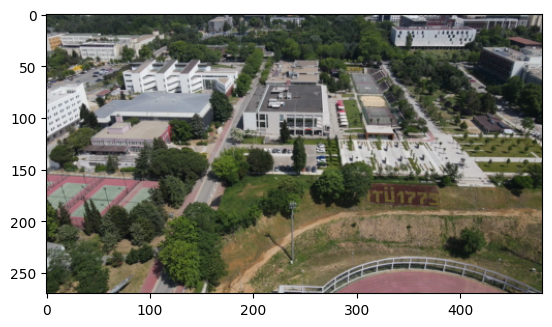

In [7]:
plt.imshow(gts[1].reshape(270,480,-1))

In [8]:
batch_size = 1024
dataloader = DataLoader(
    torch.cat((rays_o, rays_d, gts), dim=1),
    batch_size=batch_size,
    shuffle=True
)

In [87]:
class Voxels(nn.Module):
    
    def __init__(self, nb_voxels=100, scale=1, device="cpu") -> None:
        super(Voxels, self).__init__()
        
        self.nb_voxels = nb_voxels
        self.voxels    = torch.rand((self.nb_voxels,self.nb_voxels,self.nb_voxels,4), device=device) # XYZ,RGBA
        self.scale = scale
        self.device = device
        
    def forward(self, X):
        """
        X: nb_rays*nb_bins,3
        """
        x = X[:,0]
        y = X[:,1]
        z = X[:,2]
        
        # Are given points inside voxel grid?
        cond = (x.abs() <(self.scale/2.)) & (y.abs() <(self.scale/2.)) & (z.abs() <(self.scale/2.)) 
        # Digitize (Coordinate -> Index)
        indx = (x[cond] / (self.scale/self.nb_voxels) + self.nb_voxels/2).type(torch.long)
        indy = (y[cond] / (self.scale/self.nb_voxels) + self.nb_voxels/2).type(torch.long)
        indz = (z[cond] / (self.scale/self.nb_voxels) + self.nb_voxels/2).type(torch.long)
        
        colors_densities = torch.zeros((X.shape[0],4),dtype=torch.float32, device=self.device)
        colors_densities[cond, :3] = self.voxels[indx,indy,indz,:3]
        colors_densities[cond, -1] = self.voxels[indx,indy,indz,-1] * 10
        
        return torch.sigmoid(colors_densities[:,:3]), torch.relu(colors_densities[:,-1:])
        
    def intersect(self,X):
        return self.forward(X)

In [94]:
model = Voxels(scale=0.02)
ro,rd = initialize_rays(270,480, 1200,1200)
H = np.eye(4)
H[2,2] -= 1.
ro,rd = apply_camera_transformation(ro,rd,torch.Tensor(H))
img = rendering([model],ro,rd)

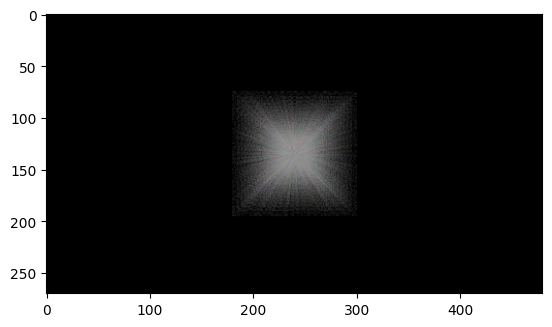

In [95]:
plt.imshow(img.reshape(270,480,-1).detach().numpy())